<a href="https://colab.research.google.com/github/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/df-filtering/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
!wget https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/accident.py?raw=true
!mv accident.py\?raw\=true accident.py

--2020-12-06 01:50:55--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/accident.py?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/accident.py [following]
--2020-12-06 01:50:55--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/accident.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/accident.py [following]
--2020-12-06 01:50:55--  https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/accident.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.co

In [3]:
pip install osmnx

In [125]:
import osmnx as ox
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from accident import ACCIDENT

In [5]:
G = ox.graph_from_place('Toronto, Ontario, Canada', network_type='drive')

In [ ]:
#G = ox.consolidate_intersections(ox.project_graph(G), tolerance=30, rebuild_graph=True)

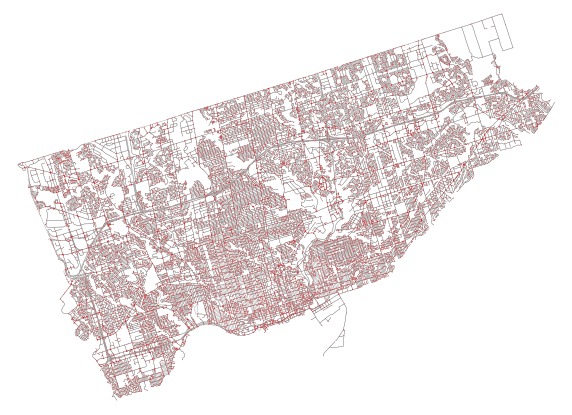

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph(G, bgcolor='white', node_size=0.3, node_color="red", edge_linewidth=0.4, edge_alpha=1, dpi=300, figsize=(10,10))

In [ ]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 27460
Number of edges: 73230
Average in degree:   2.6668
Average out degree:   2.6668


In [ ]:
edges =  list(G.edges.data())
edges[160]

(3463503,
 3463505,
 {'geometry': <shapely.geometry.linestring.LineString at 0x7f25d2d918d0>,
  'highway': 'secondary',
  'lanes': '4',
  'length': 119.022,
  'maxspeed': '50',
  'name': 'Lawrence Avenue East',
  'oneway': False,
  'osmid': 163720386})

In [ ]:
nodes =  list(G.nodes.data())
nodes[1]

(1497798, {'osmid': 1497798, 'x': -79.3355379, 'y': 43.7580721})

In [ ]:
nx.number_of_selfloops(G)

763

## KSI Dataset:

In [6]:
ksi_df = gpd.read_file("https://opendata.arcgis.com/datasets/cc17cc27ee5a4989b78d9a3810c6c007_0.geojson")

In [7]:
ksi_df.head()

,Index_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,District,WardNum,Division,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Hood_ID,Neighbourhood,ObjectId,geometry
0,3389067,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,50 to 54,Major,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),1,POINT (-79.31880 43.69960)
1,3389068,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,15 to 19,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),2,POINT (-79.31880 43.69960)
2,3389069,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Driver,55 to 59,Minor,None,North,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),3,POINT (-79.31880 43.69960)
3,3389070,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,20 to 24,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),4,POINT (-79.31880 43.69960)
4,3389071,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,15 to 19,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),5,POINT (-79.31880 43.69960)


In [8]:
def assign_injury_index(injury:str):
  if injury == "Minimal":
    return 0.4
  elif injury == "Minor":
    return 0.6
  elif injury == "Major":
    return 0.8
  elif injury == "Fatal":
    return 1.0
  else:
    return 0.2

In [9]:
ksi_df["INJ_INDEX"] = ksi_df["INJURY"].apply(lambda x: assign_injury_index(x))

In [10]:
index_df = ksi_df[["ACCNUM", "INJ_INDEX"]].groupby(by="ACCNUM").sum()

Combining Date and Hour to have one single column:

In [ ]:
# ksi_df["DATE"] = pd.to_datetime(ksi_df['DATE']).dt.floor("D") + pd.to_timedelta(ksi_df["HOUR"], unit="hour")

Add datapoints to keep here:

In [11]:
cols_to_keep = ["LATITUDE", "LONGITUDE", "ACCNUM", "TIME", "VISIBILITY", "LIGHT",	"RDSFCOND"]
ksi_df = ksi_df[cols_to_keep]

Counting fatalities using duplicate rows:

In [12]:
fatalities = ksi_df["ACCNUM"].value_counts()
ksi_df["FATALITIES"] = ksi_df["ACCNUM"].apply(lambda x : fatalities[x])

In [13]:
ksi_df = ksi_df.drop_duplicates()
ksi_df.reset_index(drop=True, inplace=True)

In [14]:
ksi_df["G_NODE"]= ox.get_nearest_nodes(G, ksi_df["LONGITUDE"], ksi_df["LATITUDE"], method="balltree")
ksi_df.drop(["LATITUDE", "LONGITUDE"], axis=1, inplace=True)

In [15]:
ksi_df = ksi_df.merge(index_df, on="ACCNUM")

In [16]:
ksi_df = ksi_df.infer_objects()
ksi_df

,ACCNUM,TIME,VISIBILITY,LIGHT,RDSFCOND,FATALITIES,G_NODE,INJ_INDEX
0,893184,236,Clear,Dark,Wet,8,33771082,4.2
1,909646,315,Snow,"Dark, artificial",Slush,5,158754118,2.4
2,884090,705,Other,"Dark, artificial",Wet,2,21631723,1.0
3,885782,1940,Rain,Dark,Wet,2,26007459,1.0
4,882079,2210,Clear,"Dark, artificial",Dry,2,259750208,1.0
...,...,...,...,...,...,...,...,...
5685,9002468442,657,Clear,Dawn,Wet,2,86186677,1.0
5686,9002471073,1415,Clear,Daylight,Dry,3,287946845,1.8
5687,9002481518,850,Clear,Daylight,Wet,2,1498033,1.0
5688,9002496688,2324,Clear,"Dark, artificial",Dry,2,392516842,1.0


Creating column of accident objects:

In [17]:
ksi_df["ACCIDENT"] = ksi_df.apply(lambda x: ACCIDENT(x["ACCNUM"], x["TIME"], x["VISIBILITY"], x["LIGHT"], x["RDSFCOND"], x["FATALITIES"], x["INJ_INDEX"]), axis=1)

In [18]:
ksi_df

,ACCNUM,TIME,VISIBILITY,LIGHT,RDSFCOND,FATALITIES,G_NODE,INJ_INDEX,ACCIDENT
0,893184,236,Clear,Dark,Wet,8,33771082,4.2,"ACCIDENT(acc_id='893184', date='236', visibili..."
1,909646,315,Snow,"Dark, artificial",Slush,5,158754118,2.4,"ACCIDENT(acc_id='909646', date='315', visibili..."
2,884090,705,Other,"Dark, artificial",Wet,2,21631723,1.0,"ACCIDENT(acc_id='884090', date='705', visibili..."
3,885782,1940,Rain,Dark,Wet,2,26007459,1.0,"ACCIDENT(acc_id='885782', date='1940', visibil..."
4,882079,2210,Clear,"Dark, artificial",Dry,2,259750208,1.0,"ACCIDENT(acc_id='882079', date='2210', visibil..."
...,...,...,...,...,...,...,...,...,...
5685,9002468442,657,Clear,Dawn,Wet,2,86186677,1.0,"ACCIDENT(acc_id='9002468442', date='657', visi..."
5686,9002471073,1415,Clear,Daylight,Dry,3,287946845,1.8,"ACCIDENT(acc_id='9002471073', date='1415', vis..."
5687,9002481518,850,Clear,Daylight,Wet,2,1498033,1.0,"ACCIDENT(acc_id='9002481518', date='850', visi..."
5688,9002496688,2324,Clear,"Dark, artificial",Dry,2,392516842,1.0,"ACCIDENT(acc_id='9002496688', date='2324', vis..."


## Dataset Filtering

VISIBILITY:

In [19]:
notclear_df = ksi_df.loc[~ksi_df.VISIBILITY.isin(["Clear"])]

In [20]:
clear_df = ksi_df.loc[ksi_df.VISIBILITY.isin(["Clear"])]

RDSFCOND:

In [21]:
dry_road_df = ksi_df.loc[ksi_df.RDSFCOND.isin(["Dry"])]

In [22]:
wet_road_df = ksi_df.loc[ksi_df.RDSFCOND.isin(["Wet"])]

In [23]:
other_road_df = ksi_df.loc[~ksi_df.RDSFCOND.isin(["Dry", "Wet"])]

Time of Day:

In [28]:
ksi_df.TIME = pd.to_numeric(ksi_df.TIME, errors='coerce')
rush_hour_df = ksi_df.loc[(ksi_df.TIME.between(630,930, inclusive=True)) | (ksi_df.TIME.between(1500,1900, inclusive=True))]

In [30]:
day_time_df = ksi_df.loc[ksi_df.TIME.between(701,1900, inclusive=True)]

In [31]:
night_time_df = ksi_df.loc[ksi_df.TIME.between(1901,700, inclusive=True)]

## Processing a given Dataset

Set the Dataset to work on:

In [200]:
given_df = rush_hour_df

Collapsing dataset to get list of accidents for each node:

In [201]:
given_df = given_df.groupby('G_NODE')['ACCIDENT'].apply(list).reset_index(name='ACCIDENTS')

In [202]:
given_df

,G_NODE,ACCIDENTS
0,1497983,"[ACCIDENT(acc_id='7000804511', date='1630', vi..."
1,1498018,"[ACCIDENT(acc_id='6001623474', date='1830', vi..."
2,1498033,"[ACCIDENT(acc_id='9002481518', date='850', vis..."
3,1498128,"[ACCIDENT(acc_id='3001877674', date='837', vis..."
4,3458707,"[ACCIDENT(acc_id='9000402520', date='1755', vi..."
...,...,...
1763,7450278104,"[ACCIDENT(acc_id='1328002', date='1900', visib..."
1764,7606751368,"[ACCIDENT(acc_id='940240', date='1821', visibi..."
1765,7870612852,"[ACCIDENT(acc_id='987506', date='1605', visibi..."
1766,8043199175,"[ACCIDENT(acc_id='6002100980', date='1807', vi..."


Converting dataset to dict to set node attributes:

In [203]:
attr = given_df.set_index('G_NODE')['ACCIDENTS'].to_dict()

In [204]:
nx.set_node_attributes(G, [], "accident_list")
nx.set_node_attributes(G, attr, "accident_list")

Example Nodes:

In [ ]:
G.nodes[3458858]

In [ ]:
G.nodes[158754118]

In [205]:
#check if node has an accident list if so
#go through each edge on the node if the edge is connecting to a node that also has an injury index then
#add its length to the cumulative length
#W base = no of accidents * avg inj_index for each accident on the node
#distribute weight to edges as follows, total length/edge length * Wbase

def getEdgeWeights(df):
  #dictionary of edge tuples to weight
  weights = {}

  sumGraphWeights = 0 #used to get the sum of all injury indexes in the 
  sumGraphNodes = 0
  #loop through each node
  for node in df['G_NODE']:
    #if G.nodes[node]['accident_list'] !=[]:
    totalLen = 0     
    totalWeight = 0    
    sumGraphNodes += 1
    for edge in nx.edges(G, node):
      totalLen += G.get_edge_data(edge[0], edge[1])[0]['length']
    for x in G.nodes[node]['accident_list']:
      totalWeight += x.inj_index
      sumGraphWeights += x.inj_index
    baseWeight = totalWeight/len(G.nodes[node]['accident_list'])
    for edge in nx.edges(G, node):
      weights[(edge[0], edge[1], 0)] = (totalLen/G.get_edge_data(edge[0], edge[1])[0]['length']) * baseWeight
  
  avgWeight = sumGraphWeights/sumGraphNodes
  
  for node in G.nodes:
    if G.nodes[node]['accident_list'] == []:
      totalLen = 0
      totalWeight = 0
      for edge in nx.edges(G, node):
        totalLen += G.get_edge_data(edge[0], edge[1])[0]['length']
      for edge in nx.edges(G, node):
        weights[(edge[0], edge[1], 0)] = (totalLen/G.get_edge_data(edge[0], edge[1])[0]['length']) *avgWeight

  return weights


In [ ]:
weights = getEdgeWeights(given_df)
nx.set_edge_attributes(G, 0, 'w')
nx.set_edge_attributes(G, weights, 'w')
nx.get_edge_attributes(G, 'w')

In [188]:
edges =  list(G.edges.data())
edges[999]

(21098690,
 4178866020,
 {'highway': 'tertiary',
  'lanes': '4',
  'length': 9.08,
  'maxspeed': '40',
  'name': 'Park Lawn Road',
  'oneway': False,
  'osmid': 417323680,
  'w': 13.56740088105727})

## PageRank

In [207]:
def pagerank_top_50(G):
  pr = nx.pagerank_scipy(G, weight='w')
  pr = pd.DataFrame.from_dict(pr, orient='index').sort_values(by=0, ascending=False).rename(columns={0:"PageRank Score"})
  return pr.iloc[:50]

In [ ]:
top_50 = pagerank_top_50(G)
top_50

In [114]:
top_50_nodes = list(top_50.index.values)

## Clustering

In [209]:
def most_central_edge(net):
    centrality = nx.edge_betweenness_centrality(net, k = 25)
    return max(centrality, key=centrality.get)

In [210]:
gn = girvan_newman(G, most_valuable_edge=most_central_edge)
limited = itertools.takewhile(lambda c: len(c) <= 100, gn)

In [211]:
communities = None
for communities in limited:
    pass
community_tuple = tuple(c for c in communities)

In [212]:
cc1 = community_tuple[0]
cc2 = community_tuple[1]
cc3 = community_tuple[2]
cc4 = community_tuple[3]

## Printing Graphs

In [213]:
# nc = ['red' if node in cc else 'gray' for node in G.nodes()]
# ec = ['red' if (edge[0] in cc) or (edge[1] in cc) else 'gray' for edge in G.edges()]
ec = []
for edge in G.edges():
  if (edge[0] in cc1) or (edge[1] in cc1):
    ec.append('red')
  elif (edge[0] in cc2) or (edge[1] in cc2):
    ec.append('blue')
  elif (edge[0] in cc3) or (edge[1] in cc3):
    ec.append('green')
  elif (edge[0] in cc4) or (edge[1] in cc4):
    ec.append('orange')
  else:
    ec.append("gray")

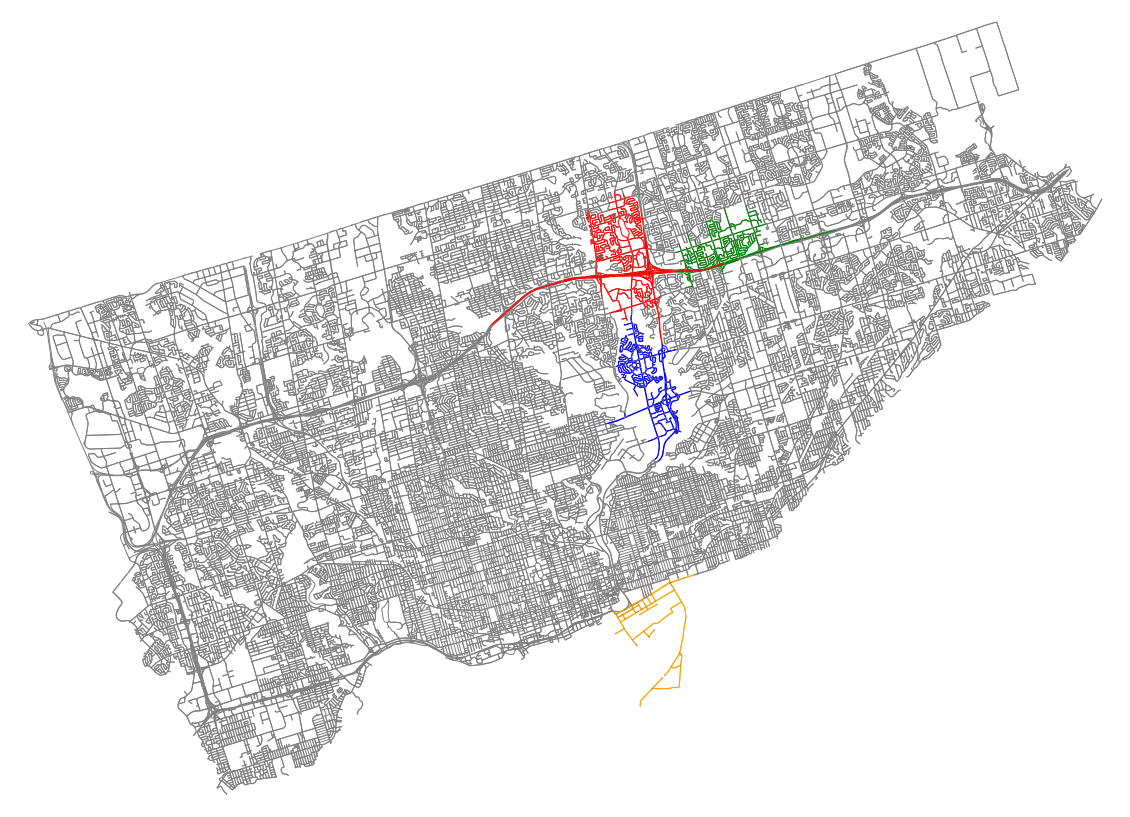

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [214]:
ox.plot_graph(G, bgcolor='white', node_size=1.0, node_color='gray', edge_color=ec, edge_linewidth=1.0, edge_alpha=1, dpi=300, figsize=(20,20))